In [1]:
from compute import Var, eqvar
#from inputresolver import reassigneq, eqvars, eqsonly, default_out, mdf_order, default_in, idx_eqlist
import numpy as np
import sympy as sp
#import networkx as nx
#from representations import draw, bipartite_repr, digraph_repr
from datastructures.api import Model, adda, addf, addsolver, setsolvefor, addobj, addineq
from datastructures.workflow import OPT
from datastructures.nestedgraph import merge_graph
from collections import OrderedDict
from datastructures.runpipeline import run_valid_formulation

In [2]:
import matplotlib.pyplot as plt

In [3]:
from datastructures.graphutils import namefromid, dfs_tree, Node, SOLVER, VAR, COMP, flat_graph_formulation, filter_comps, draw_graph_graphical_props
from datastructures.execution import generate_components_and_residuals
from datastructures.workflow import get_f, order_from_tree, default_solver_options, mdao_workflow, implicit_comp_name
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.assembly import build_archi
import openmdao.api as om

In [28]:
b = [2, 2.5, 3]
w = np.array([1.3, 1.5, 1.2])
a1e = 0.2

In [29]:
model = Model(solver=OPT)
m = model.root

In [30]:
x1, x2, x3, a2, a3 = Var('x_1'), Var('x_2'), Var('x_3'), Var('a_2'), Var('a_3')
a1 = adda(m, 'a_1', 0.1*x1*a2+0.8*x1*a3+b[0])
adda(m, a2, x2*a3+b[1])
adda(m, a3, 0.1*x3*a1+0.8*x3*a2+b[2])
a4 = adda(m, 'a_4', (a1-a1e)**2+sp.Matrix([x1**2,x2**2,x3**2]).dot(w**2))
#addobj(m, a4)

In [31]:
setsolvefor(m, [x1,x2,x3])

In [32]:
edges, tree = model.generate_formulation()

In [33]:
edges

({0: ('a_3', 'x_1', 'a_2'),
  1: ('a_3', 'x_2'),
  2: ('a_1', 'a_2', 'x_3'),
  3: ('x_1', 'a_1', 'x_2', 'x_3')},
 {0: ('a_1',), 1: ('a_2',), 2: ('a_3',), 3: ('a_4',)},
 {})

In [34]:
from representations import draw

In [35]:
nodetyperepr = {VAR: '{}', COMP: 'f_{}', SOLVER: 'p_{}'}
#Ein = filter_comps(edges[0], [1,2])
#Eout = filter_comps(edges[1], [1,2])
G = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr)

In [36]:
merge1 = {Node(1, COMP), Node(2, COMP)}
merge2 = {Node(0, COMP), Node(3, COMP)}

In [43]:
G_merge, G_sub1 = merge_graph(G, merge1, set(), solver_idx=1, nodetyperepr=nodetyperepr, exclude_unique_sources=False)
G_merge, G_sub2 = merge_graph(G_merge, merge2, set(), solver_idx=2, nodetyperepr=nodetyperepr, exclude_unique_sources=False)

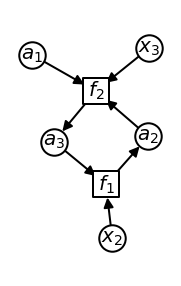

In [44]:
draw_graph_graphical_props(G_sub1, figsize=(3,5));

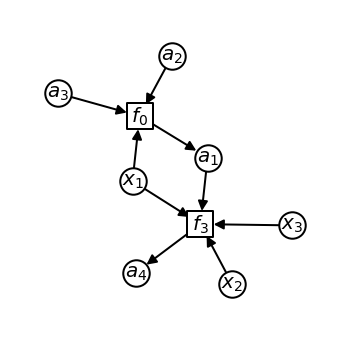

In [45]:
draw_graph_graphical_props(G_sub2);

In [47]:
edges

({0: ('a_3', 'x_1', 'a_2'),
  1: ('a_3', 'x_2'),
  2: ('a_1', 'a_2', 'x_3'),
  3: ('x_1', 'a_1', 'x_2', 'x_3')},
 {0: ('a_1',), 1: ('a_2',), 2: ('a_3',), 3: ('a_4',)},
 {})

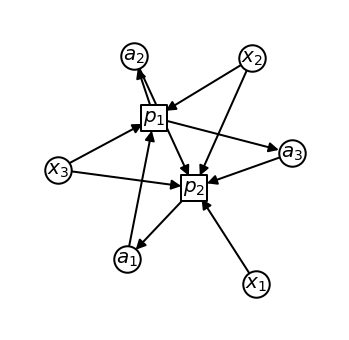

In [46]:
draw_graph_graphical_props(G_merge, prog='fdp');

In [10]:
def reorder(tree, order):
    d = OrderedDict()
    Ftree = tree[0]
    for elt in order:
        d[elt] = Ftree[elt]
    for key,var in Ftree.items():
        if key not in d:
            d[key]=var
    return d, tree[1], tree[2]

In [52]:
order = [1,0,2]

In [53]:
rtree = reorder(tree, order)
for elt in order:
    rtree[0][elt] = 2
rtree[1][2] = 1
rtree[2]['a1']=2
rtree[2]['a2']=2
rtree[2]['a3']=2

In [54]:
ordered_tree = rtree
ordered_edges = edges
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
solvers_options[1].update({'optimizer': 'L-BFGS-B', 'maxiter': 75})
solvers_options[2] = {'solver': 'GS', 'maxiter':20}
nodetyperepr = model.nametyperepr
namingfunc = namefromid(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [64]:
model.components

[(('a2', 'x1', 'a3'), 0, ('a1',), '0.1*a2*x1 + 0.8*a3*x1 + 2'),
 (('x2', 'a3'), 1, ('a2',), 'a3*x2 + 2.5'),
 (('x3', 'a1', 'a2'), 2, ('a3',), '0.1*a1*x3 + 0.8*a2*x3 + 3'),
 (('x3', 'x2', 'a1', 'x1'), 3, (None,), '1.69*x1**2 + 2.25*x2**2 + 1.44*x3**2 + (a1 - 0.2)**2')]

In [56]:
components = model.components
all_components = generate_components_and_residuals(components, ordered_edges)

In [57]:
all_components

[(('a2', 'x1', 'a3'), 0, ('a1',), '0.1*a2*x1 + 0.8*a3*x1 + 2'),
 (('x2', 'a3'), 1, ('a2',), 'a3*x2 + 2.5'),
 (('x3', 'a1', 'a2'), 2, ('a3',), '0.1*a1*x3 + 0.8*a2*x3 + 3'),
 (('x3', 'x2', 'a1', 'x1'), 3, (None,), '1.69*x1**2 + 2.25*x2**2 + 1.44*x3**2 + (a1 - 0.2)**2')]

In [58]:
lookup_f = get_f(all_components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc)

In [59]:
recorder = om.SqliteRecorder("cases.sqlite")
solver = prob.model.s2.nonlinear_solver
solver.add_recorder(recorder)
#solver.recording_options['includes'] = ['*']
#solver.recording_options['record_outputs'] = True
#solver.options['use_apply_nonlinear'] = True

In [60]:
#prob.model.s1.f3.add_recorder(recorder)

In [61]:
for key,val in ordered_tree[0].items():
    s = groups[namingfunc(val, SOLVER)]
    f = getattr(s, namingfunc(key, COMP))
    f.recording_options['options_excludes'] = ['component']

In [62]:
#prob.setup();

In [63]:
prob.run_driver();


==
s2
==
NL: NLBGS Converged in 14 iterations

==
s2
==
NL: NLBGS Converged in 1 iterations

==
s2
==
NL: NLBGSSolver 'NL: NLBGS' on system 's2' failed to converge in 20 iterations.

==
s2
==
NL: NLBGS Converged in 14 iterations
Optimization Complete
-----------------------------------


In [50]:
prob.cleanup();

In [24]:
cr = om.CaseReader("cases.sqlite")
solver_cases = cr.list_cases(out_stream=None);

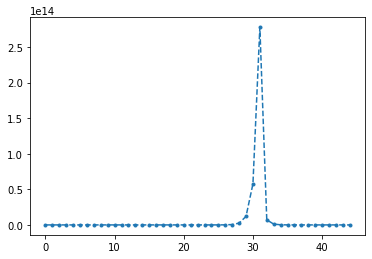

In [25]:
plt.plot([cr.get_case(elt).get_val('a3') for elt in solver_cases], '.--');

In [44]:
last_case = cr.get_case(solver_cases[1])

In [27]:
last_case.list_outputs();

4 Explicit Output(s) in 's1'

varname  val         
-------  ------------
s2
  f1
    a2   [6.11164591]
  f2
    a3   [4.14782579]
  f0
    a1   [2.81228746]
f3
  obj3   [8.67312201]


0 Implicit Output(s) in 's1'




In [54]:
prob.model.list_outputs();

7 Explicit Output(s) in 'model'

varname   val          
--------  -------------
inp
  x1      [-0.50713742]
  x3      [0.17880901] 
  x2      [0.0474264]  
s1
  s2
    f0
      a1  [0.48996124] 
    f1
      a2  [2.66074577] 
    f2
      a3  [3.3893732]  
  f3
    obj3  [0.56982733] 


0 Implicit Output(s) in 'model'




In [90]:
prob.model.s1.s2.iter_count_apply

35